<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y funciones

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def covarianzas(v, r_a=0.25, sigma_c=1, r_c=1/57):
  covA=np.zeros((20,20))
  covC=np.zeros((20,20))
  for s in range(20):
    covC[s,s] = (sigma_c**2)*(1-np.exp(-2*r_c*v*(s+1)/sigma_c))
    covA[s,s] = (r_a**2)*((s+1)**2)
    for t in range(s):
        covC[t,s] = covC[s,t]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(t+1)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
        covA[t,s] = covA[s,t]=(r_a**2)*((t+1)**2)
  return covA, covC


In [3]:
def simula_coord_de_separcion(d, n):
    """Simula las coordenadas along y cross de separación entre pares de
       aviones con trayectorias paralel, que parten de d millas náuticas, donde:
       d: es la distancia inicial entre dos aviones,
       n: es la cantidad de simulaciones de vuelos paralelos"""
    𝜇 = np.zeros(20) + d/2
    coord_a = np.random.multivariate_normal(mean=np.zeros(20), cov=2*covA, size=n)
    coord_c = np.random.multivariate_normal(mean=2*𝜇, cov=2*covC, size=n)

    return coord_a, coord_c

# Simulaciones con modelo AR (Construcción de la cadena de markov)

A partir de una primera simulación de las distancias entre dos aviones por un periodo de 20 min, la siguiente simulación se calculará mediante el siguiente modelo autorregresivo, añadiendo una componente de inovación.

$$Z_{i} = \phi(Z_{i-1}-2\mu) + \sqrt{1-\phi^{2}}(I_{i}-2\mu) +2\mu$$

donde:

- $\phi(Z_{i-1}-2\mu)$  es la parte de la trayectoria previa que conservamos, y
- $ \sqrt{1-\phi^{2}}(I_{i}-2\mu) $ es la parte de innovación que se añade.

Si la distancia minima de la nueva simulación es menor a cierta distancia establecida, enonces esa nueva simulación pasará a formar parte de la cadena, si no, la nueva simulación será identica que la anterior:



$$Z_{i} = Z_{i-1} $$

In [12]:
v = 8      # (nmi/min)(nmi -> millas naúticas)
d = 8              # separación entre par de aviones (nmi)
d_conflicto = 0.1  # separación a partir de la cual dos aviones entran en conflicto (nmi)
n = 15000          # numero de simulaciones en la cadena de markov

covA, covC = covarianzas(v=v)

# Simulamos nuestra primer vector de distancias entre dos aviones con
# trayectorias paralelas "startingpoint" (1 observación de la Cadena de Markov)

Z_a, Z_c  = simula_coord_de_separcion(d=d, n=1)
startingPoint = np.concatenate((Z_a, Z_c), axis=1)
startingPoint.shape

(1, 40)

$$Z_{i} = \phi(Z_{i-1}-2\mu) + \sqrt{1-\phi^{2}}(I_{i}-2\mu) +2\mu$$

In [22]:
def simula_cadenaMarkov(n, d, startingPoint, dist_parcial = float("inf")):

        Z_a = startingPoint[:,:20]
        Z_c = startingPoint[:,20:]

        # Simulamos n vectores de distancia entre dos aviones iid, que aportará la
        # innovación para la construcción de la cadena de Markov
        I_a, I_c = simula_coord_de_separcion(d=d, n=n)

        𝜇 = np.zeros(20) + d/2
        𝜙 = 0.9
        𝜙_bar = np.sqrt(1 - 𝜙**2)
        for i in range(n-1):
            newZ_a = 𝜙*(Z_a[-1:,]) + 𝜙_bar*(I_a[i,:])
            newZ_c = 𝜙*(Z_c[-1:,] - 2*𝜇) + 𝜙_bar*(I_c[i,:] - 2*𝜇) + 2*𝜇

            # Se calcula la distancia minima de la nueva simulación(d_newZ).
            d_newZ = np.sqrt(np.min(newZ_a**2 + newZ_c**2))

            # Se considerará la nueva simulación cuando d_newZ sea menor o igual
            # a la distancia de referencia, en caso contrario nos quedaremos con
            # la trayectoria anterior.
            Z_a = np.append(
                Z_a,
                newZ_a*(d_newZ <= dist_parcial) + Z_a[-1]*(d_newZ > dist_parcial),
                axis=0
            )
            Z_c = np.append(
                Z_c,
                newZ_c*(d_newZ <= dist_parcial) + Z_c[-1]*(d_newZ > dist_parcial),
                axis=0
            )
        Z = np.concatenate((Z_a, Z_c), axis=1)
        return Z

In [14]:
# Simulamos n distancias entre pares de aviones

Z = simula_cadenaMarkov(n, d, startingPoint)


# Encontrar distancias parciales convenientes

In [16]:
# Calculamos el valor mínimo por simulacion
distancia_minima = np.sqrt(np.min(Z[:, :20]**2 + Z[:, 20:]**2, axis=1))

# Ordenamos el vector distancias de manera ascendente
distancia_minima = np.sort(distancia_minima)

# Elegimos el cuantil 2 de las distancias menores
cuantil =0.02
inx = int(n * cuantil)

# Obtenemos la primera distancia parcial
distancia_parcial = distancia_minima[inx]

print(f"Nuestra primera distancia parcial será la distancia del {inx}renglon): {distancia_parcial}")

Nuestra primera distancia parcial será la distancia del 300renglon): 4.575772871586959


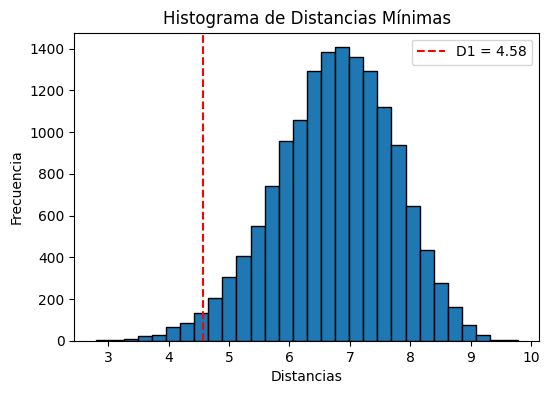

In [17]:
# Histograma
plt.figure(figsize=(6, 4))
plt.hist(distancia_minima, bins=30, edgecolor='black')
plt.axvline(x=distancia_parcial, color='red', linestyle='--',
            label=f'D1 = {distancia_parcial:.2f}')
plt.xlabel('Distancias')
plt.ylabel('Frecuencia')
plt.title('Histograma de Distancias Mínimas')
plt.legend()
_ = plt.show()


In [27]:
def identificar_distancias_parciales(n, d):
    cuantil =0.02

    # 1. Simula la primera cadena de Markov.
    Z_a, Z_c  = simula_coord_de_separcion(d=d, n=1)
    startingPoint = np.concatenate((Z_a, Z_c), axis=1)
    Z = simula_cadenaMarkov(n, d, startingPoint)

    # 2. Ordena las simulaciones de manera ascendente considerando la distancia
    # minima en cada simulación.
    Z = np.array(sorted(list(Z), key=lambda x:min(x[:20]**2 + x[20:]**2)))

    # 3. Identificamos la trayectoria en el cuantil 0.2
    inx = int(n * cuantil)

    # 4. Guardamos la distancia mínima del renglón  identificado.
    distancias_parciales = np.array([])
    distancia_minima = np.sqrt(np.min((Z[inx,:20]**2 + Z[inx, 20:]**2)))
    distancias_parciales = np.append(distancias_parciales, distancia_minima)

    # Repetimos el proceso mientras la distancia encontrada sea mayor
    # que la distancia de conflicto.
    while (distancias_parciales[-1] > a):
        # 1. Comenzamos una nueva cadena de Markov considerando el startingpoint
        #    la Z con la menor distancia ocurrida en la simulación anterior y la
        #    distancia de referencia identificada en la iteración anterior.
        startingPoint = (Z[0]).reshape(1,-1)
        Z = simula_cadenaMarkov(n, d, startingPoint, distancias_parciales[-1])

        # 2. Ordena las simulaciones en base a la distancia minima en cada simulación.
        Z = np.array(sorted(list(Z), key=lambda x: min(x[:20]**2+x[20:]**2)))

        # 3. Nos quedamos con el (1-cuantil)% de simulaciones en que se acercaron más los aviones.
        #    Identificamos la trayectoria que separa con el criterio descrito.
        inx = int(n * cuantil)

        # 4. Guardamos la minima distancia minima del renglón vector identificado.
        distancia_minima = np.sqrt(np.min((Z[inx,:20]**2 + Z[inx, 20:]**2)))
        distancias_parciales = np.append(distancias_parciales, distancia_minima)

    # 5. Nos aseguramos de que el primer nivel sea a.
    distancias_parciales = distancias_parciales[:-1]
    distancias_parciales = np.append(distancias_parciales, a)

    distancias_parciales=list(dict.fromkeys(distancias_parciales))

    return distancias_parciales

In [28]:
a = 0.1
𝜙 = 0.9
𝜙_bar = np.sqrt(1-𝜙**2)
d = 10
n = 15000

distancias_parciales = identificar_distancias_parciales(n, d)

for dist in distancias_parciales:
  print(dist)

6.524146699723459
5.008419487005678
3.754810653496634
2.7497063697875666
1.871788051958088
1.0521298438332214
0.328434451191848
0.1


# Encontrar la probabilidad de conflicto usando las distancias parciales

In [53]:
def probaAR(n, d):

    # 0. DIVIDIMOS LA DISTANCIA d en DISTANCIAS PARCIALES
    distancias_parciales = identificar_distancias_parciales(n, d)

    # 1.CREAMOS EL PUNTO DE INICIO DE LA PRIMERA CADENA DE MARKOV
    Z_a, Z_c  = simula_coord_de_separcion(d=d, n=1)
    startingPoint = np.concatenate((Z_a, Z_c), axis=1)


    # 2. CONSTRUIMOS LA PRIMERA CADENA DE MARKOV
    Z = simula_cadenaMarkov(n, d, startingPoint)

    # 3. CALCULAMOS LA DISTANCIA MINIMA DE CADA SIMULACIÓN
    l = np.sqrt(np.amin(Z[:,:20]**2 + Z[:,20:]**2,axis=1))

    # 4. ESTIMAMOS LA PROBABILIDAD DE QUE SE LLEGUE A LA PRIMERA DISTANCIA PARCIAL
    P_vec = np.array(np.mean(l <= distancias_parciales[0]))  # se guarda en el vector P_vec

    for dist in range(1, len(distancias_parciales)):

        # 1. ELECCION DEL PUNTO DE PARTIDA DE LA NUEVA CADENA DE MARKOV
        d_parcial_ant = distancias_parciales[(dist-1)]
        if sum(l <= d_parcial_ant) > 0:
            # Si existe, se elige una trayectoria que haya llegado a la distancia de referencia anterior
            startingPoint = (Z[l <= d_parcial_ant][0]).reshape(1,-1)
        else:
            # Si no hay ninguna, se empieza con la que tenga la distancia más pequeña
            Z = np.array(sorted(list(Z),
                                key=lambda x:min(x[:20]**2 + x[20:]**2)))
            startingPoint = (Z[0]).reshape(1,-1)

        # 2. SIMULACION DE LA NUEVA CADENA DE MARKOV
        Z = simula_cadenaMarkov(n, d, startingPoint, d_parcial_ant)

        # 3. CALCULAMOS LA DISTANCIA MINIMA DE CADA SIMULACIÓN
        l = np.sqrt(np.amin(Z[:,:20]**2 + Z[:,20:]**2, axis=1))

        # 4. CALCULAMOS LA PROBABILIDAD DE ALCANZAR LA DISTANCIA PARCIAL
        P_vec = np.append(P_vec, np.mean(l <= distancias_parciales[dist]))

    # 5. CALCULAMOS LA PROBABILIDAD DE CONFLICTO COMO EL PRODUCTO DE LAS PROBABILIDADES CONDICIONALES.
    P = np.prod(P_vec)
    proba_parciales_df = pd.DataFrame({'Distancias Parciales': distancias_parciales,
                                    'Probabilidades Parciales':P_vec})
    resultados= {'Distancias Parciales': np.array(distancias_parciales),
                 'Probabilidades Parciales':P_vec,
                 'Probabilidad de Conflicto':P}
    print(f"La probabilidad de que dos aviones, que salesn a {d:.2f} nmi de \
distancia, entren en conflicto es de {P}")

    return resultados

In [63]:
n = 15000
d = 8
resultados_8 = probaAR(n,d)

La probabilidad de que dos aviones, que salesn a 8.00 nmi de distancia, entren en conflicto es de 1.1140864440005357e-09


In [64]:
import pandas as pd
pd.DataFrame({'DistanciasParciales': resultados_8['Distancias Parciales'],
              'ProbabilidadesParciales': resultados_8['Probabilidades Parciales']})

,DistanciasParciales,ProbabilidadesParciales
0,4.622774,0.021667
1,3.022369,0.018467
2,1.849912,0.023733
3,0.809105,0.015467
4,0.180116,0.021533
5,0.100000,0.352267


In [65]:
d = 7
probaAR(n, d)

La probabilidad de que dos aviones, que salesn a 7.00 nmi de distancia, entren en conflicto es de 3.601505361237334e-08


{'Distancias Parciales': array([3.61274584, 2.02959993, 0.90352922, 0.18886665, 0.1       ]),
 'Probabilidades Parciales': array([0.0218    , 0.0174    , 0.0232    , 0.01386667, 0.29513333]),
 'Probabilidad de Conflicto': np.float64(3.601505361237334e-08)}

In [66]:
d = 6
probaAR(n, d)

La probabilidad de que dos aviones, que salesn a 6.00 nmi de distancia, entren en conflicto es de 1.1867124456296296e-06


{'Distancias Parciales': array([2.68270567, 1.23343338, 0.291483  , 0.1       ]),
 'Probabilidades Parciales': array([0.02373333, 0.026     , 0.02313333, 0.08313333]),
 'Probabilidad de Conflicto': np.float64(1.1867124456296296e-06)}

In [67]:
d = 5
probaAR(n, d)

La probabilidad de que dos aviones, que salesn a 5.00 nmi de distancia, entren en conflicto es de 1.5244528888888888e-05


{'Distancias Parciales': array([1.75455448, 0.43452588, 0.1       ]),
 'Probabilidades Parciales': array([0.02073333, 0.01793333, 0.041     ]),
 'Probabilidad de Conflicto': np.float64(1.5244528888888888e-05)}

In [68]:
d = 4
probaAR(n, d)

La probabilidad de que dos aviones, que salesn a 4.00 nmi de distancia, entren en conflicto es de 0.00019730427022222218


{'Distancias Parciales': array([1.00856912, 0.1494689 , 0.1       ]),
 'Probabilidades Parciales': array([0.02253333, 0.01946667, 0.4498    ]),
 'Probabilidad de Conflicto': np.float64(0.00019730427022222218)}

In [69]:
d = 4
probaAR(n,d)

La probabilidad de que dos aviones, que salesn a 4.00 nmi de distancia, entren en conflicto es de 0.00020671317333333333


{'Distancias Parciales': array([0.86731427, 0.14262521, 0.1       ]),
 'Probabilidades Parciales': array([0.01613333, 0.02773333, 0.462     ]),
 'Probabilidad de Conflicto': np.float64(0.00020671317333333333)}

In [70]:
d = 4
probaAR(n,d)

La probabilidad de que dos aviones, que salesn a 4.00 nmi de distancia, entren en conflicto es de 0.00020910709925925927


{'Distancias Parciales': array([0.94453427, 0.14109876, 0.1       ]),
 'Probabilidades Parciales': array([0.02126667, 0.01693333, 0.58066667]),
 'Probabilidad de Conflicto': np.float64(0.00020910709925925927)}